In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:  # if running with Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    import sys
    # the location where you saved the tools.py and csv files
    drive_dir = '/content/drive/My Drive/Colab Notebooks/FCTT 3'
    sys.path.insert(0, drive_dir)

    data_dir = os.path.join(drive_dir, 'battery_experimental_data')
    fit_res_dir = os.path.join(drive_dir, 'fitting_results')
except:  # if running locally
    data_dir = os.path.abspath('battery_experimental_data')
    fit_res_dir = os.path.abspath('fitting_results')
    
from tools import *

## Load data

In [2]:
SOC_OCV_data = pd.read_csv(os.path.join(data_dir, 'SOC_OCV_MFCTT_2019.csv'), sep='\t')
testing_data = pd.read_csv(os.path.join(data_dir, 'Battery_Testing_Data.csv'), header=0, skiprows=[1])

ref_SOC = SOC_OCV_data['SOC'].values               # unit in %
ref_OCV = SOC_OCV_data['Ecell/V'].values           # unit in V

t = testing_data['Time (s)'].values                # unit in s
I = -testing_data['Current (mA)'].values / 1000    # unit in A
T = testing_data['Temperature'].values + 273.15    # unit in A
V_actual = testing_data['Voltage (V)'].values      # unit in V

In [3]:
T0 = 293.15
R = 8.31446261815324

def fit_R0(I=None, z=None, T=T):
    R0_const, E = read_fit_res(fit_res_dir, 'R0')
    R0_val = R0_const * np.exp(-(E / R)*(1/T - 1/T0))
    return R0_val


def fit_R1(I=I, z=None, T=T):
    _, b, c, d = read_fit_res(fit_res_dir, 'R1_gauss')
    E = read_fit_res(fit_res_dir, 'R1_arr')
    R1_const = read_fit_res(fit_res_dir, 'R1')
    R1_val = R1_const * np.exp(-((I-b)**2) / c) * np.exp(-(E/R) * (1/T - 1/T0)) + d
    
    return R1_val


def fit_C1(I=None, z=None, T=None):
    C1_const = read_fit_res(fit_res_dir, 'C1')
    C1_val = C1_const
    return C1_val

In [4]:
V_pred = first_order_ECN(t, I, T, V_actual, ref_OCV, ref_SOC,
                         fit_R0, fit_R1, fit_C1)

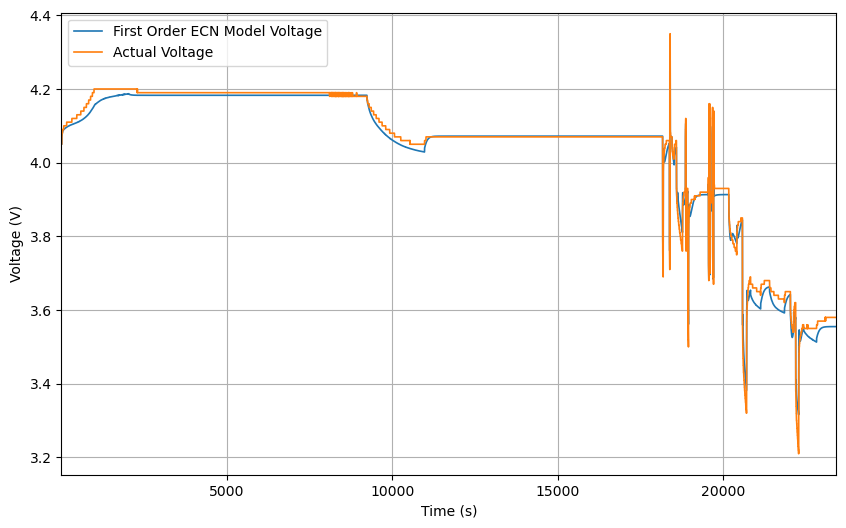

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [5]:
# %matplotlib notebook
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, V_pred, label='First Order ECN Model Voltage', linewidth=1.2)
ax.plot(t, V_actual, label='Actual Voltage', linewidth=1.2)
ax.legend()
ax.set_xlim([t[0], t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.grid()
# ax.set_title('First Order ECN Model Prediction')
plt.show()
fig.savefig('Figures/Part 2/2d_model.eps', format='eps')

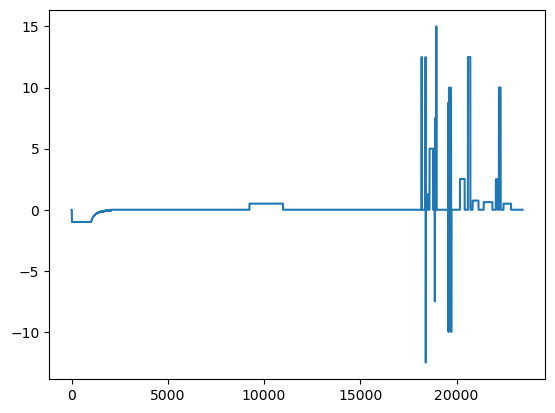

In [6]:
plt.plot(t, I)
plt.show()

## Error Analysis

In [12]:
error = V_pred - V_actual
error_pct = (V_pred - V_actual) / V_actual

max_idx = np.argmax(np.abs(error))
max_err = error[max_idx]
t_max_err = t[max_idx]

max_idx_pct = np.argmax(np.abs(error_pct))
max_err_pct = error_pct[max_idx_pct]
t_max_err_pct = t[max_idx_pct]

print("Maximum error is {:.4f} V, at t = {} s".format(max_err, t_max_err))
print("Maximum percentage error is {:.4f}%, at t = {} s".format(max_err_pct*100, t_max_err_pct))

print()

avg_err = np.mean(np.abs(error))
avg_err_pct = np.mean(np.abs(error_pct))

print("Average error (absolute) is {:.4f} V".format(avg_err))
print("Average percentage error (absolute) is {:.4f}%".format(avg_err_pct*100))

print()

rms = np.sqrt(np.mean(np.square(error)))
print("RMS error is {:.4f} V".format(rms))

Maximum error is 0.1587 V, at t = 18395 s
Maximum percentage error is 3.8810%, at t = 18395 s

Average error (absolute) is 0.0116 V
Average percentage error (absolute) is 0.2985%

RMS error is 0.0172 V


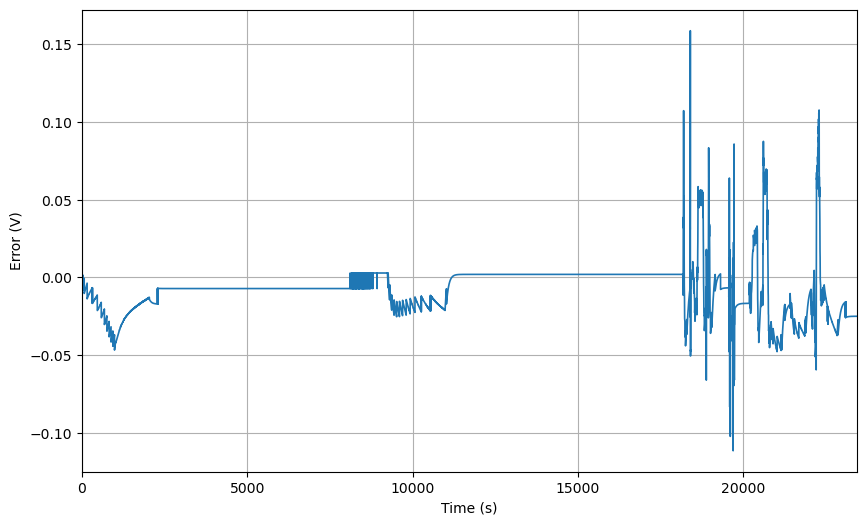

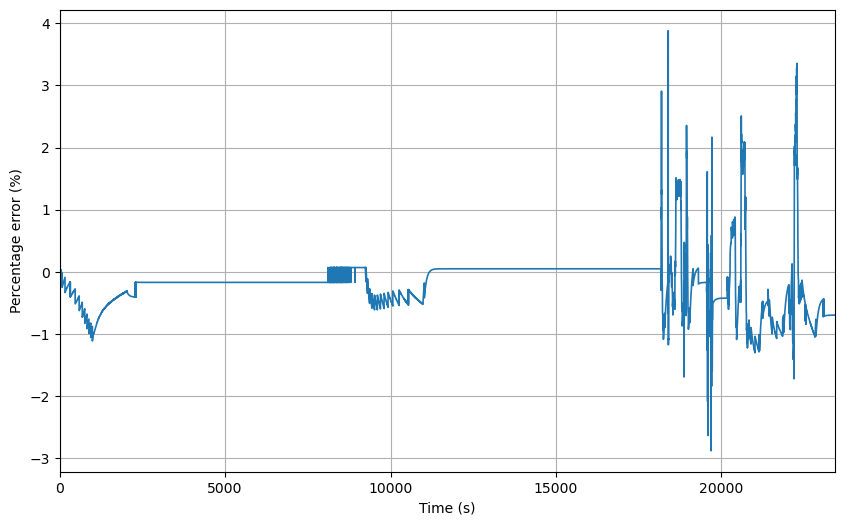

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, error, linewidth=1.2)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Error (V)')
ax.grid()
# ax.set_title('First Order ECN Model Error')
plt.show()
fig.savefig('Figures/Part 2/2d_error_absolute.eps', format='eps')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, error_pct*100, linewidth=1.2)
ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Percentage error (%)')
ax.grid()
# ax.set_title('First Order ECN Model Error')
plt.show()
fig.savefig('Figures/Part 2/2d_error_percentage.eps', format='eps')

### Placeholder Values

In [15]:
def fit_R0_ph(I=None, z=None, T=T):
    return 0.04

def fit_R1_ph(I=I, z=None, T=T):
    return 0.005

def fit_C1_ph(I=None, z=None, T=None):
    return 5000

V_pred_ph = first_order_ECN(t, I, T, V_actual, ref_OCV, ref_SOC,
                            fit_R0_ph, fit_R1_ph, fit_C1_ph)

error_ph = V_pred_ph - V_actual
error_pct_ph = (V_pred_ph - V_actual) / V_actual

max_idx = np.argmax(np.abs(error_ph))
max_err = error_ph[max_idx]
t_max_err = t[max_idx]

max_idx_pct = np.argmax(np.abs(error_pct_ph))
max_err_pct = error_pct_ph[max_idx_pct]
t_max_err_pct = t[max_idx_pct]

print("Maximum error is {:.4f} V, at t = {} s".format(max_err, t_max_err))
print("Maximum percentage error is {:.4f}%, at t = {} s".format(max_err_pct*100, t_max_err_pct))

print()

avg_err = np.mean(np.abs(error))
avg_err_pct = np.mean(np.abs(error_pct))

print("Average error (absolute) is {:.4f} V".format(avg_err))
print("Average percentage error (absolute) is {:.4f}%".format(avg_err_pct*100))

print()

rms = np.sqrt(np.mean(np.square(error)))
print("RMS error is {:.4f} V".format(rms))

Maximum error is 0.4377 V, at t = 18395 s
Maximum percentage error is 10.7006%, at t = 18395 s

Average error (absolute) is 0.0116 V
Average percentage error (absolute) is 0.2985%

RMS error is 0.0172 V


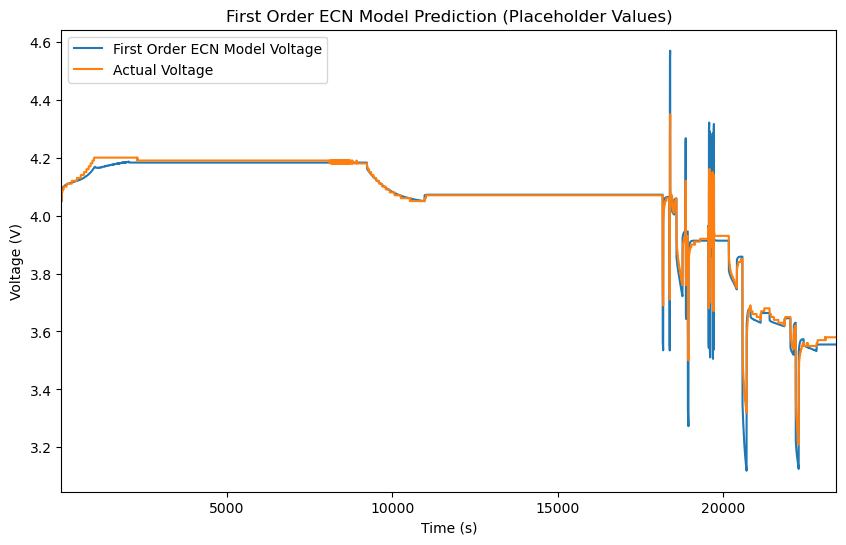

In [16]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, V_pred_ph, label='First Order ECN Model Voltage')
ax.plot(t, V_actual, label='Actual Voltage')
ax.legend()
ax.set_xlim([t[0], t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('First Order ECN Model Prediction (Placeholder Values)')
plt.show()